<a href="https://colab.research.google.com/github/is0280fp/google_colab/blob/use_image_as_input/training_spectrogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# ラベルの読み込み
import pickle
# with open("/content/drive/MyDrive/pickle/label_five_class.pickle", mode="rb") as f:
#    label = pickle.load(f)
# f.close()
with open("/content/drive/MyDrive/pickle/label_HC_vs_GD_class.pickle", mode="rb") as f:
   label = pickle.load(f)
f.close()
# with open("/content/drive/MyDrive/pickle/HC_A_C_label.pickle", mode="rb") as f:
#    label = pickle.load(f)
# f.close()

# with open("/content/drive/MyDrive/pickle/HC_A_C_file_name.pickle", mode="rb") as f:
#    data = pickle.load(f)
# f.close()

In [3]:
# データセット内訳チェック
import numpy as np

print(np.array(np.where(label == 0)).shape)
print(np.array(np.where(label == 1)).shape)
print(np.array(np.where(label == 2)).shape)
print(np.array(np.where(label == 3)).shape)
print(np.array(np.where(label == 4)).shape)

# NaNチェック
print(np.isnan(label).sum())

(1, 7755)
(1, 12748)
(1, 19873)
(1, 21386)
(1, 13970)
0


In [51]:
data.shape

(43111,)

In [9]:
import tensorflow as tf
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, InputLayer, Dense, Dropout, Activation, Flatten, concatenate, Conv1D, MaxPooling1D, Input, Reshape, Bidirectional, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler
import time
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras
from PIL import Image
import numpy as np

# NAME = "HC-vs-C-LSTM_2class"
# NAME = "HC-vs-A-LSTM_2class"
# NAME = "HC-vs-K-LSTM_2class"
# NAME = "HC-vs-H-LSTM_2class"
# NAME = "HC-vs-GDs-LSTM_2class"
# NAME = "H-vs-K-vs-A-vs-C-LSTM_4class"
#NAME = "HC-vs-H-vs-K-vs-A-vs-C-LSTM_5class"
# NAME = "H-vs-K-vs-A-vs-C-CNN_4class"
NAME = "HC-vs-Patients-CNN_5class"
# NAME = "HC-vs-GDs-CNN_2class"
# NAME = "HC-vs-H-CNN_2class"
# NAME = "HC-vs-K-CNN_2class"
# NAME = "HC-vs-A-CNN_2class"
# NAME = "HC-vs-C-CNN_2class"

#-----------------------------------初期設定-------------------------------------------
# tensorboardのログ
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

# 学習打ち切り目安
early_stopping = EarlyStopping(
                        monitor='val_loss',
                        min_delta=0.0,
                        patience=10,
                )

# checkpointの設定
checkpoint = ModelCheckpoint(
                    filepath="saved_model/{}".format(NAME),
                    monitor='val_loss',
                    save_best_only=True,
                    period=1,
                )

In [10]:
# 入力データの加工

def conv_binary(number):
  V_left_filename = '/content/spectrogram_data/V_left/{}.png'.format(number)
  V_right_filename = '/content/spectrogram_data/V_right/{}.png'.format(number)
  # AP_left_filename = '/content/spectrogram_data/AP_left/{}.png'.format(number)
  # AP_right_filename = '/content/spectrogram_data/AP_right/{}.png'.format(number)
  # ML_left_filename = '/content/spectrogram_data/ML_left/{}.png'.format(number)
  # ML_right_filename = '/content/spectrogram_data/ML_right/{}.png'.format(number)


  V_left_img = Image.open(V_left_filename)
  V_right_img = Image.open(V_right_filename)
  # AP_left_img = Image.open(AP_left_filename)
  # AP_right_img = Image.open(AP_right_filename)
  # ML_left_img = Image.open(ML_left_filename)
  # ML_right_img = Image.open(ML_right_filename)

  V_left_img = V_left_img.resize(size=(224, 112), resample=Image.BICUBIC)
  V_right_img = V_right_img.resize(size=(224, 112), resample=Image.BICUBIC)
  # AP_left_img = AP_left_img.resize(size=(114, 76), resample=Image.BICUBIC)
  # AP_right_img = AP_right_img.resize(size=(114, 76), resample=Image.BICUBIC)
  # ML_left_img = ML_left_img.resize(size=(114, 76), resample=Image.BICUBIC)
  # ML_right_img = ML_right_img.resize(size=(114, 76), resample=Image.BICUBIC)

  V_left_rgb = np.array(V_left_img.convert('RGB')).astype('float32')
  V_right_rgb = np.array(V_right_img.convert('RGB')).astype('float32')
  # AP_left_rgb = np.array(AP_left_img.convert('RGB')).astype('float32')
  # AP_right_rgb = np.array(AP_right_img.convert('RGB')).astype('float32')
  # ML_left_rgb = np.array(ML_left_img.convert('RGB')).astype('float32')
  # ML_right_rgb = np.array(ML_right_img.convert('RGB')).astype('float32')

  V_left_rgb /= 255.0
  V_right_rgb /= 255.0
  # AP_left_rgb /= 255.0
  # AP_right_rgb /= 255.0
  # ML_left_rgb /= 255.0
  # ML_right_rgb /= 255.0

  # V_img_array = np.concatenate([V_left_rgb, V_right_rgb], axis=0)
  # AP_img_array = np.concatenate([AP_left_rgb, AP_right_rgb], axis=0)
  # ML_img_array = np.concatenate([ML_left_rgb, ML_right_rgb], axis=0)
  # img_array = np.concatenate([V_img_array, AP_img_array, ML_img_array], axis=1)

  # V_img_array = np.concatenate([V_left_rgb, V_right_rgb], axis=1)
  # AP_img_array = np.concatenate([AP_left_rgb, AP_right_rgb], axis=1)
  # ML_img_array = np.concatenate([ML_left_rgb, ML_right_rgb], axis=1)
  # img_array = np.concatenate([V_img_array, AP_img_array, ML_img_array], axis=0)

  # img_array = np.concatenate([V_img_array, AP_img_array, ML_img_array], axis=0)
  img_array = np.concatenate([V_left_rgb, V_right_rgb], axis=0)
  return img_array

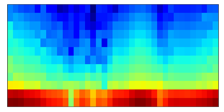

In [68]:
# 入力画像確認用
number=1
V_left_filename = '/content/spectrogram_data/V_left/{}.png'.format(number)
V_right_filename = '/content/spectrogram_data/V_right/{}.png'.format(number)
AP_left_filename = '/content/spectrogram_data/AP_left/{}.png'.format(number)
AP_right_filename = '/content/spectrogram_data/AP_right/{}.png'.format(number)
ML_left_filename = '/content/spectrogram_data/ML_left/{}.png'.format(number)
ML_right_filename = '/content/spectrogram_data/ML_right/{}.png'.format(number)


V_left_img = Image.open(V_left_filename)
V_right_img = Image.open(V_right_filename)
AP_left_img = Image.open(AP_left_filename)
AP_right_img = Image.open(AP_right_filename)
ML_left_img = Image.open(ML_left_filename)
ML_right_img = Image.open(ML_right_filename)

V_left_img = V_left_img.resize(size=(224, 112), resample=Image.BICUBIC)
V_right_img = V_right_img.resize(size=(224, 112), resample=Image.BICUBIC)
AP_left_img = AP_left_img.resize(size=(114, 76), resample=Image.BICUBIC)
AP_right_img = AP_right_img.resize(size=(114, 76), resample=Image.BICUBIC)
ML_left_img = ML_left_img.resize(size=(114, 76), resample=Image.BICUBIC)
ML_right_img = ML_right_img.resize(size=(114, 76), resample=Image.BICUBIC)

V_left_rgb = np.array(V_left_img.convert('RGB')).astype('float32')
V_right_rgb = np.array(V_right_img.convert('RGB')).astype('float32')
AP_left_rgb = np.array(AP_left_img.convert('RGB')).astype('float32')
AP_right_rgb = np.array(AP_right_img.convert('RGB')).astype('float32')
ML_left_rgb = np.array(ML_left_img.convert('RGB')).astype('float32')
ML_right_rgb = np.array(ML_right_img.convert('RGB')).astype('float32')

V_left_rgb /= 255.0
V_right_rgb /= 255.0
AP_left_rgb /= 255.0
AP_right_rgb /= 255.0
ML_left_rgb /= 255.0
ML_right_rgb /= 255.0

# V_img_array = np.concatenate([V_left_rgb, V_right_rgb], axis=0)
# AP_img_array = np.concatenate([AP_left_rgb, AP_right_rgb], axis=0)
# ML_img_array = np.concatenate([ML_left_rgb, ML_right_rgb], axis=0)

# img_array = np.concatenate([V_img_array, AP_img_array, ML_img_array], axis=1)

# V_img_array = np.concatenate([V_left_rgb, V_right_rgb], axis=1)
# AP_img_array = np.concatenate([AP_left_rgb, AP_right_rgb], axis=1)
# ML_img_array = np.concatenate([ML_left_rgb, ML_right_rgb], axis=1)

# img_array = np.concatenate([V_img_array, AP_img_array, ML_img_array], axis=0)

img_array = np.concatenate([V_left_rgb, V_right_rgb], axis=0)

V_left_img
V_right_img

In [69]:
img_array.shape

(224, 224, 3)

In [11]:
def get_batch(batch_size, X, Y):
    """
    batchを取得する関数
    """
    SIZE = len(X)
    # n_batchs
    n_batchs = SIZE//batch_size
    # for でyield
    i = 0
    while ((i+batch_size) < SIZE):
        # print("doing", i, "/", n_batchs)
        # Y_batch = Y[(i * n_batchs):(i * n_batchs + batch_size)]
        Y_batch = Y[i:(i + batch_size)]
        
        #あるbatchのfilenameの配列を持っておく
        # X_batch_name = X[(i * n_batchs):(i * n_batchs + batch_size)]
        X_batch_name = X[i:(i + batch_size)]

        # filenameにしたがってバッチのtensorを構築
        X_batch = np.array([conv_binary(file) for file in X_batch_name])
        
        # これで(batch_size, 28, 28, 1)のtrainのテンソルが作られる
        i += 1
        yield X_batch, Y_batch

In [ ]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D,Input, Dropout
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import CSVLogger
from sklearn.model_selection import StratifiedKFold

n_categories=5
N_EPOCHS = 1000
# 32, 64, 128, 256, 400 overfitting
BATCH_SIZE = 64

# acquire the .png name
TRAINS = np.array(range(len(label)))
# TRAINS = data
y = label
# # split test and train
# X_train, X_test, Y_train, Y_test = train_test_split(
#     TRAINS, y, test_size=0.1, random_state=42)

# split test and the others
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(
    TRAINS, y, test_size=0.1, random_state=42)

# split k-folds (その中の一つのfoldがvalidationのためのtestデータとなる)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for X_index, Y_index in skf.split(X_train_and_val, Y_train_and_val):
    # print("train_index:", train_index, "val_index:", val_index)
    # print("train data", X_train_and_val[X_index])
    # print("train label", Y_train_and_val[X_index])
    # print("test data", X_train_and_val[Y_index])
    # print("test label", Y_train_and_val[Y_index])

    train_data = X_train_and_val[X_index]
    train_label = Y_train_and_val[X_index]
    test_data = X_train_and_val[Y_index]
    test_label = Y_train_and_val[Y_index]

    steps_per_epoch=len(X_train_and_val[X_index])//BATCH_SIZE 
    validation_steps=len(X_train_and_val[Y_index])//BATCH_SIZE 

training_generator = get_batch(BATCH_SIZE, train_data, train_label)
validation_generator = get_batch(BATCH_SIZE, test_data, test_label)

vgg_model = VGG16(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

#add new layers instead of FC networks
x=vgg_model.output
x=Flatten()(x) # Flatten dimensions to for use in FC layers
x=Dense(256, activation='relu', activity_regularizer=regularizers.l1(l1=0.02))(x)
x=Dropout(0.6)(x) # Dropout layer to reduce overfitting
# x = Dense(256, activation='relu')(x)
x = Dense(n_categories, activation='softmax')(x) # Softmax for multiclass
transfer_model = Model(inputs=vgg_model.input, outputs=x)

#fix weights before VGG16 14layers
for layer in vgg_model.layers[:15]:
    layer.trainable=False

transfer_model.compile(optimizer=optimizers.Adam(lr=5e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

transfer_model.summary()

hist=transfer_model.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=N_EPOCHS
    )

#save weights
transfer_model.save(file_name+'.h5')

In [ ]:
print(steps_per_epoch)
print(len(X_train_and_val[X_index]))
print(BATCH_SIZE)

In [ ]:
import gc
gc.collect()

In [ ]:
print(X_train_and_val[X_index].shape)
print(X_index.shape)
print(X_train_and_val[X_index][0])
print(X_index[0])
TRAINS

In [ ]:
# データの読み込み 
# yesを選ぶように!
!unzip /content/drive/MyDrive/zip_spectrogram_data/AP_left.zip
!unzip /content/drive/MyDrive/zip_spectrogram_data/AP_right.zip
!unzip /content/drive/MyDrive/zip_spectrogram_data/AP_right_69826.zip

In [ ]:
# データの読み込み
# yesを選ぶように!
!unzip /content/drive/MyDrive/zip_spectrogram_data/ML_left.zip
!unzip /content/drive/MyDrive/zip_spectrogram_data/ML_left_58106.zip
!unzip /content/drive/MyDrive/zip_spectrogram_data/ML_right.zip

In [ ]:
# データの読み込み
# yesを選ぶように!
!unzip /content/drive/MyDrive/zip_spectrogram_data/V_left.zip
!unzip /content/drive/MyDrive/zip_spectrogram_data/V_left_48327.zip
!unzip /content/drive/MyDrive/zip_spectrogram_data/V_right.zip
!unzip /content/drive/MyDrive/zip_spectrogram_data/V_right_34533.zip

In [ ]:
img = Image.open("/content/spectrogram_data/ML_left/58106.png")
img